In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from scipy import ndimage
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:


# Leer los datos
emociones = pd.read_csv("./icml_face_data.csv", delimiter=",")
emociones.columns = emociones.columns.str.strip()

# Limitar los datos a los primeros 1000 ejemplos
emociones = emociones.iloc[0:1000]

# Convertir la columna de píxeles a matrices de píxeles y normalizar
emociones['pixels'] = emociones['pixels'].apply(lambda x: np.array(x.split()).reshape(48, 48, 1).astype(float))/255

# Función para aplicar el volteo horizontal a las imágenes
def horizontal_flip(image):
    return np.flip(image, axis=1)

# Función para rotar las imágenes por un ángulo específico
def rotate_image(image, angle):
    return ndimage.rotate(image, angle, reshape=False)

# Función para aumentar aleatoriamente el brillo de las imágenes
def increase_brightness(image):
    return np.clip(random.uniform(1.5, 2) * image, 0.0, 255.0)

# Función para disminuir aleatoriamente el brillo de las imágenes
def decrease_brightness(image):
    return np.clip(random.uniform(0, 1) * image, 0.0, 255.0)

# Función para aplicar un ligero desenfoque a las imágenes
def apply_blur(image):
    noise = np.random.randint(low=0, high=255, size=image.shape)
    factor = 0.25
    return image + (noise * factor)

# Función para redimensionar las imágenes
def resize_image(image, new_size):
    return cv2.resize(image.squeeze(), new_size)

# Tamaño deseado para las imágenes aumentadas
IMAGE_SHAPE = (224, 224)

# Aplicar las transformaciones y agregar las imágenes modificadas al DataFrame
emociones_augmented = pd.DataFrame(columns=['emotion', 'pixels'])

for idx, row in emociones.iterrows():
    original_image = row['pixels']
    resized_original_image = resize_image(original_image, IMAGE_SHAPE)
    emotion = row['emotion']

    # Aplicar las transformaciones
    rotated_image = rotate_image(resized_original_image, random.randint(-30, 30))
    brightened_image = increase_brightness(resized_original_image)
    darkened_image = decrease_brightness(resized_original_image)

    # Redimensionar las imágenes
    # resized_original_image = resize_image(original_image, IMAGE_SHAPE)
    # resized_rotated_image = resize_image(rotated_image, new_size)
    # resized_brightened_image = resize_image(brightened_image, new_size)
    # resized_darkened_image = resize_image(darkened_image, new_size)

    # Agregar las imágenes modificadas al DataFrame
    emociones_augmented = emociones_augmented.append({'emotion': emotion, 'pixels': resized_original_image}, ignore_index=True)
    emociones_augmented = emociones_augmented.append({'emotion': emotion, 'pixels': rotated_image}, ignore_index=True)
    emociones_augmented = emociones_augmented.append({'emotion': emotion, 'pixels': brightened_image}, ignore_index=True)
    emociones_augmented = emociones_augmented.append({'emotion': emotion, 'pixels': darkened_image}, ignore_index=True)

emociones_augmented = shuffle(emociones_augmented)

# Preparar los datos para el entrenamiento
emociones = emociones_augmented['emotion']
one_hot_labels = to_categorical(emociones)
X_train, X_test, y_train, y_test = train_test_split(emociones_augmented['pixels'], one_hot_labels, test_size=0.2, random_state=42)
# Preparar los datos para el entrenamiento
X_train = np.stack(X_train.values)  # Convertir a numpy array y apilar
X_test = np.stack(X_test.values)  # Convertir a numpy array y apilar
# Ajustar la forma de los datos de entrada
X_train = np.expand_dims(X_train, axis=-1)  # Agregar una dimensión adicional para el canal de color
X_test = np.expand_dims(X_test, axis=-1)  # Agregar una dimensión adicional para el canal de color

AttributeError: 'DataFrame' object has no attribute 'append'

Epoch 1/45
100/100 [==============================] - 118s 1s/step - loss: 1.3546 - accuracy: 0.4250 - val_loss: 1.1416 - val_accuracy: 0.5250
Epoch 2/45
100/100 [==============================] - 108s 1s/step - loss: 1.0362 - accuracy: 0.5797 - val_loss: 1.0452 - val_accuracy: 0.5788
Epoch 3/45
100/100 [==============================] - 110s 1s/step - loss: 0.9148 - accuracy: 0.6388 - val_loss: 0.9952 - val_accuracy: 0.5962
Epoch 4/45
100/100 [==============================] - 108s 1s/step - loss: 0.8355 - accuracy: 0.6862 - val_loss: 0.9424 - val_accuracy: 0.6375
Epoch 5/45
100/100 [==============================] - 110s 1s/step - loss: 0.7770 - accuracy: 0.7009 - val_loss: 0.9230 - val_accuracy: 0.6400
Epoch 6/45
100/100 [==============================] - 110s 1s/step - loss: 0.7189 - accuracy: 0.7322 - val_loss: 0.8941 - val_accuracy: 0.6513
Epoch 7/45
100/100 [==============================] - 111s 1s/step - loss: 0.6775 - accuracy: 0.7578 - val_loss: 0.8956 - val_accuracy: 0.6488

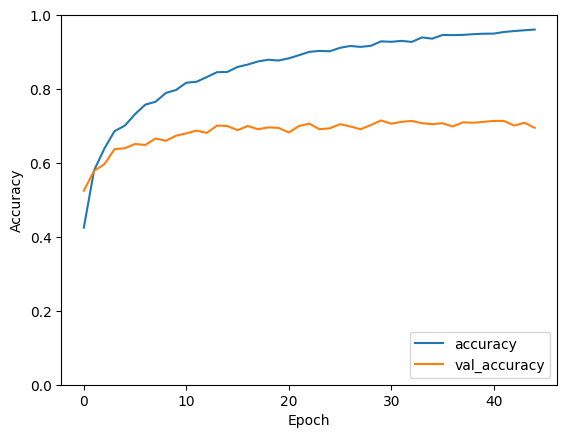

In [9]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(resnet_url,
                                         trainable=False,
                                         input_shape=(224, 224, 3),
                                         name='feature_extraction_layer')

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(5, activation='softmax', name='output_layer')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
X_train_rgb = np.repeat(X_train, 3, -1)
X_test_rgb = np.repeat(X_test, 3, -1)
history = model.fit(X_train_rgb, y_train, epochs=45, validation_data=(X_test_rgb, y_test), batch_size=32, verbose=1, shuffle=True)
# Visualizar la precisión de entrenamiento y validación
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [6]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow_hub as hub

def findEmotion(numero):
    return {
        0: "Ira",
        1: "Asco",
        2: "Tristeza",
        3: "Felicidad",
        4: "Sorpresa",
    }[numero]

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(resnet_url,
                                         trainable=False,
                                         input_shape=(224, 224, 3),
                                         name='feature_extraction_layer')

# Define the custom objects dictionary
custom_objects = {'KerasLayer': feature_extractor_layer}

with tf.keras.utils.custom_object_scope(custom_objects):
    loaded_model = load_model('bestModel.h5')

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Cannot open camera")
    exit()
    
count_find_image = 0
while True:
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    
    if count_find_image == 30:
        frame_resized = cv2.resize(frame, (224, 224))
        frame_resized = np.expand_dims(frame_resized, axis=0)  # Add batch dimension
        frame_resized = frame_resized / 255.0  # Normalize pixel values
        clase = loaded_model.predict(frame_resized)
        print(findEmotion(np.argmax(clase)))
        count_find_image = 0
    else:
        count_find_image += 1
    
    cv2.imshow('frame', frame)

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 1s 817ms/step
Tristeza
1/1 [==============================] - 0s 105ms/step
Tristeza
1/1 [==============================] - 0s 105ms/step
Tristeza
1/1 [==============================] - 0s 106ms/step
Tristeza
1/1 [==============================] - 0s 114ms/step
Tristeza
1/1 [==============================] - 0s 107ms/step
Tristeza
1/1 [==============================] - 0s 107ms/step
Felicidad
1/1 [==============================] - 0s 106ms/step
Tristeza
1/1 [==============================] - 0s 107ms/step
Tristeza
1/1 [==============================] - 0s 103ms/step
Tristeza
1/1 [==============================] - 0s 107ms/step
Tristeza
1/1 [==============================] - 0s 107ms/step
Tristeza
1/1 [==============================] - 0s 114ms/step
Tristeza


KeyboardInterrupt: 